### Step 1 - Environment Setup and Data Download

In [4]:
# Install kagglehub library to download datasets from Kaggle
!pip install kagglehub

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 230.1 MB/s eta 0:00:00


In [5]:
# Import kagglehub package to access Kaggle datasets using the API
import kagglehub
# Download latest version
path = kagglehub.dataset_download("inzaghim/amazon-review-2024-electronics")
print("Path to dataset files:", path)

100%|██████████| 6.14G/6.14G [01:08<00:00, 96.3MB/s]

Extracting files...


Path to dataset files: /home/xyu8/.cache/kagglehub/datasets/inzaghim/amazon-review-2024-electronics/versions/1


In [6]:
# Import required libraries for data processing and NLP
import os
import nltk
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, size, split
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import word_tokenize


In [7]:
# Set for NLTK
os.environ["NLTK_DATA"] = "/home/xyu8/nltk_data"

In [8]:
# Download NLTK assets
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/xyu8/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/xyu8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Step 2 - Spark Session Setup and Data Loading

In [9]:
# Initialize spark session with specified memory and executor settings
sc = SparkSession.builder \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()

In [35]:
# Load the Electronics JSON dataset using Spark from the downloaded Kaggle path
df = sc.read.json(f"{path}/Electronics.jsonl") 

### Step 3 - Data Cleaning and Preprocessing

In [36]:
# show basic info of the dataset
print(df.columns)
print("We have {} features".format(len(df.columns) - 1))
print("Total rows {}".format(df.count()))


['asin', 'helpful_vote', 'images', 'parent_asin', 'rating', 'text', 'timestamp', 'title', 'user_id', 'verified_purchase']
We have 9 features
Total rows 43886944


In [37]:
# Keep only the columns we care about: 'text' and 'rating'
new_review_df = df.drop(*['asin', 'helpful_vote', 'images', 'parent_asin', 'timestamp', 'title', 'user_id', 'verified_purchase'])
# Show a preview
new_review_df.show(5)

+------+--------------------+
|rating|                text|
+------+--------------------+
|   3.0|First & most offe...|
|   1.0|These didn’t work...|
|   5.0|I love these. The...|
|   5.0|I was searching f...|
|   5.0|I've bought these...|
+------+--------------------+
only showing top 5 rows



In [38]:
# Drop the corrupt_record column 
new_review_df = new_review_df.drop('_corrupt_record')

In [39]:
from functools import reduce

In [40]:
# Check if any column has null values
null_rows = new_review_df.filter(reduce(lambda a, b: a | b, [col(c).isNull() for c in new_review_df.columns]))

# If nulls are found, remove them and print a message
if null_rows.count() > 0:
    print("DataFrame contains null values. Removing them now.")
    clean_review_df = new_review_df.na.drop()
else:
     # If no null values, keep the dataframe as is
    print("DataFrame has no null values.")
    clean_review_df = new_review_df

print("Total rows after removing nulls:", clean_review_df.count())

DataFrame has no null values.
Total rows after removing nulls: 43886944


In [41]:
# Convert review text to lowercase
from pyspark.sql.functions import lower
clean_review_df = clean_review_df.withColumn("lower_text", lower("text"))
clean_review_df.show(5)


+------+--------------------+--------------------+
|rating|                text|          lower_text|
+------+--------------------+--------------------+
|   3.0|First & most offe...|first & most offe...|
|   1.0|These didn’t work...|these didn’t work...|
|   5.0|I love these. The...|i love these. the...|
|   5.0|I was searching f...|i was searching f...|
|   5.0|I've bought these...|i've bought these...|
+------+--------------------+--------------------+
only showing top 5 rows



In [42]:
# clean and tokenize review text
@udf(returnType=ArrayType(StringType()))
def tokenize_text(text):
    # Import stopwords and stemmer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    if text:
        # Convert to lowercase and split by whitespace
        tokens = text.lower().split()
        # Stem words, remove stopwords and nonalphanumeric tokens
        return [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    
    return []

# Apply the tokenizer function to create a new column 'tokens'
clean_review_df = clean_review_df.withColumn("tokens", tokenize_text(col("lower_text")))

# Show the first 5 rows of lowercased text and tokens
clean_review_df.select("lower_text", "tokens").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
from pyspark.sql.functions import size, split
# Add new columns to clean_review_df
dataset = clean_review_df.withColumn("word_counts", size(split(col("lower_text"), " ")))
dataset = dataset.withColumn("tokenizes_count", size(col("tokens")))

# Display schema to confirm
dataset.printSchema()
# Show the first 5 rows including new columns for validation
dataset.select("lower_text", "word_counts", "tokens", "tokenizes_count").show(5, truncate=False)


root
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- lower_text: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word_counts: integer (nullable = false)
 |-- tokenizes_count: integer (nullable = false)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [45]:

from pyspark.sql.types import DoubleType
# Define UDF to compute average word length
# This function calculates the average number of characters per word in the token list.
def avg_word_length(tokens):
    return float(sum(len(w) for w in tokens) / len(tokens)) if tokens else 0.0

avg_word_length_udf = udf(avg_word_length, DoubleType())

# Add column to the dataset
dataset = dataset.withColumn("avg_word_length", avg_word_length_udf(col("tokens")))
dataset.select("tokens", "avg_word_length").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+
|tokens                                                                                                                                                                      

### Step 4 - Data Visualization and Correlation Analysis

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

/scratch/xyu8/job_39290488/ipykernel_1488379/662800399.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating', y='count', data=rating_counts_pd, palette='Blues')


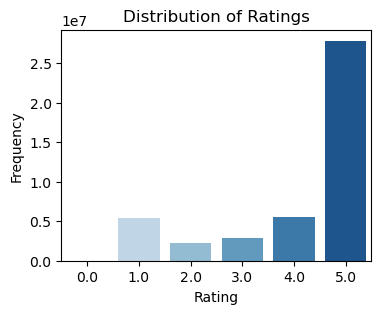

In [22]:
# Plot distribution of review ratings
rating_counts = dataset.groupBy("rating").count().orderBy("rating")
rating_counts_pd = rating_counts.toPandas()

# Plotting the distribution of review ratings using a bar plot.
# This shows how many reviews exist for each rating level.
plt.figure(figsize=(4, 3))
sns.barplot(x='rating', y='count', data=rating_counts_pd, palette='Blues')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [23]:
correlation_rating_word_counts = dataset.stat.corr("rating", "word_counts")
print(f"Correlation between rating and word_counts: {correlation_rating_word_counts}")


Correlation between rating and word_counts: -0.09964654354172987


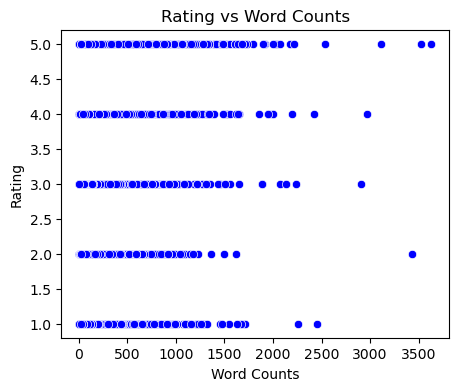

In [24]:
# Sample 1% of the dataset to reduce processing time
sampled_data = dataset.sample(fraction=0.01, seed=42)

# Select only the needed columns and convert to Pandas
sampled_data_pandas = sampled_data.select("rating", "word_counts").toPandas()

# Plotting
# This scatter plot shows the relationship between review length (word count) and rating.
# Each point represents a review. The x-axis is the number of words, and the y-axis is the rating 
# visualize whether longer or shorter reviews are associated with higher or lower ratings.
plt.figure(figsize=(5, 4))
sns.scatterplot(data=sampled_data_pandas, x='word_counts', y='rating', color='blue')
plt.title('Rating vs Word Counts')
plt.xlabel('Word Counts')
plt.ylabel('Rating')
plt.show()


/scratch/xyu8/job_39290488/ipykernel_1488379/1261095793.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="rating", y="avg_word_length", data=sampled_avg_len_df, palette="Set3")


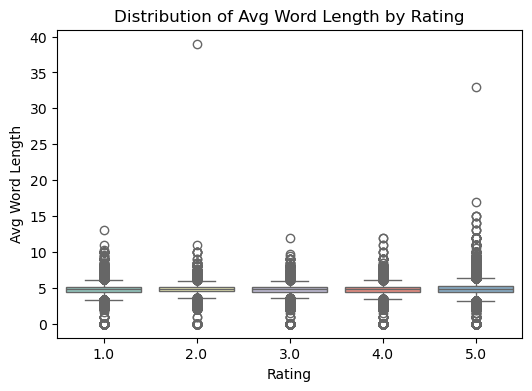

In [26]:
# distribution of average word lengths for each rating 
# Sample 1% of the dataset
sampled_avg_len_df = dataset.sample(fraction=0.01, seed=42).select("rating", "avg_word_length").toPandas()

# Visualizing the distribution of average word length for each rating using a box plot.
# This chart helps to observe the spread and median of word lengths by rating group.
plt.figure(figsize=(6, 4))
sns.boxplot(x="rating", y="avg_word_length", data=sampled_avg_len_df, palette="Set3")
plt.xlabel("Rating")
plt.ylabel("Avg Word Length")
plt.title("Distribution of Avg Word Length by Rating")
plt.show()